In [46]:
# =============================
# 📦 1. Imports & Data Loading
# =============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Load dataset
df = pd.read_csv("C:/Users/BHARGAVI/Downloads/Telecom.csv")

# Quick look
df.head()
df.info()
df.describe()
df['Churn'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [47]:
# =============================
# 🧹 2. Data Cleaning
# =============================

# Remove duplicates
df = df.drop_duplicates()

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Handle missing values
df = df.dropna()

# Convert target to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Encode categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,customerID_0003-MKNFE,customerID_0004-TLHLJ,customerID_0011-IGKFF,customerID_0013-EXCHZ,customerID_0013-MHZWF,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False


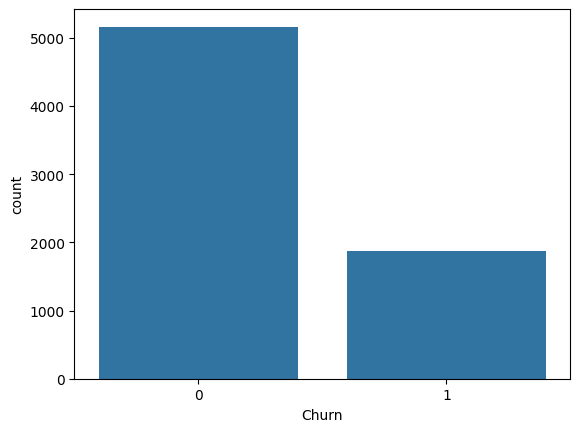

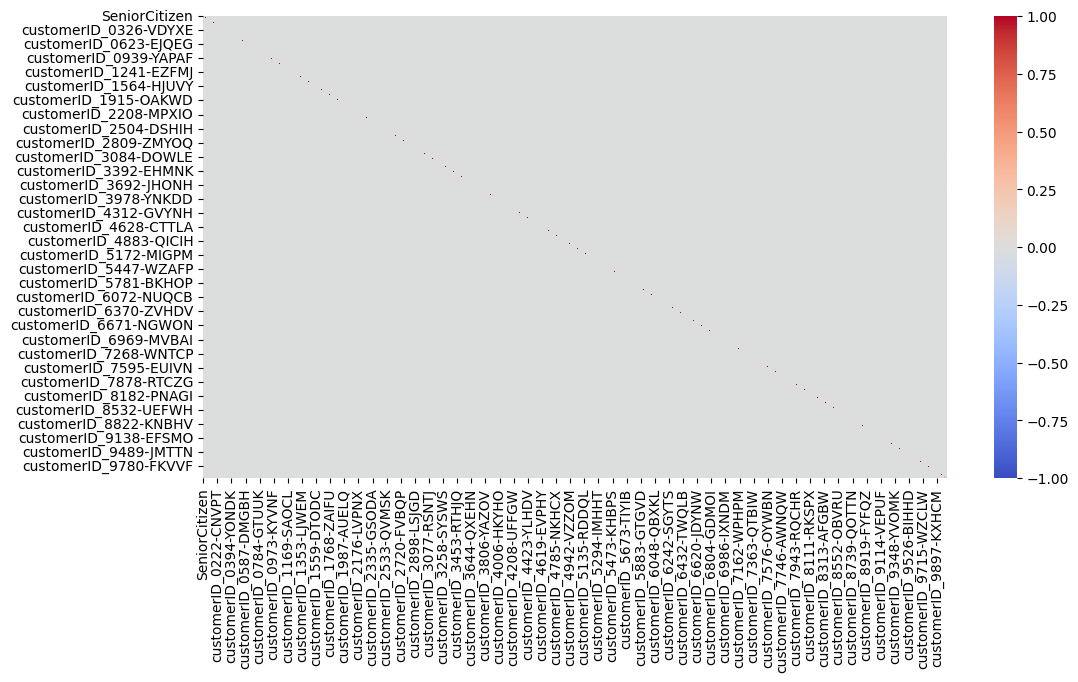

In [48]:
# =============================
# 📊 3. Exploratory Data Analysis
# =============================

sns.countplot(x='Churn', data=df)
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.show()

# Custom plots: Churn vs tenure, contract, payment, etc.


In [56]:
# =============================
# 🧠 4. Feature Engineering
# =============================

# Example: tenure groups
def tenure_group(tenure):
    if tenure <= 12:
        return 'Short'
    elif tenure <= 36:
        return 'Medium'
    else:
        return 'Long'

df['TenureGroup'] = df['tenure'].apply(tenure_group)
df = pd.get_dummies(df, columns=['TenureGroup'], drop_first=True)

# Separate X, y
X = df.drop('Churn', axis=1)
y = df['Churn']


In [57]:
print(df['Churn'].unique())
print(df['Churn'].isna().sum())


['No' 'Yes']
0


In [58]:
# Drop rows where Churn is NaN
df = df.dropna(subset=['Churn'])

# If churn is like 1.0 / 0.0, convert to Yes/No
df['Churn'] = df['Churn'].map({1: 'Yes', 0: 'No'}).fillna(df['Churn'])

# Optional: ensure it is categorical
df['Churn'] = df['Churn'].astype(str).str.strip()


In [52]:
from sklearn.model_selection import train_test_split

X = df.drop('Churn', axis=1)
y = df['Churn']

# Confirm classes are valid
print(y.value_counts())

# Only stratify if each class has >=2 samples
strat = y if y.value_counts().min() >= 2 else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=strat, random_state=42
)


Churn
No     5163
Yes    1869
Name: count, dtype: int64


In [59]:
# =============================
# 🤖 5. Model Building
# =============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(class_weight='balanced'),
    'GradientBoosting': GradientBoostingClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


C:\Users\BHARGAVI\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogisticRegression
              precision    recall  f1-score   support

          No       0.90      0.69      0.78      1033
         Yes       0.47      0.78      0.59       374

    accuracy                           0.71      1407
   macro avg       0.68      0.73      0.68      1407
weighted avg       0.78      0.71      0.73      1407

ROC-AUC: 0.8242994548871208

RandomForest
              precision    recall  f1-score   support

          No       0.83      0.90      0.86      1033
         Yes       0.63      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

ROC-AUC: 0.8268050069627428

GradientBoosting
              precision    recall  f1-score   support

          No       0.83      0.90      0.86      1033
         Yes       0.65      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0

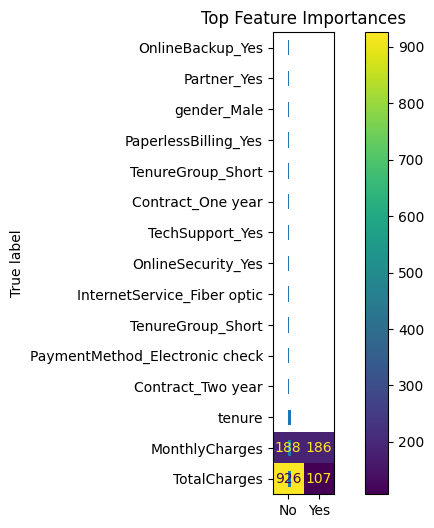

In [60]:
# =============================
# 📈 6. Evaluation & Interpretation
# =============================

# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

best_model = models['RandomForest']  # choose your best one
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

# Feature importance
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.nlargest(15).plot(kind='barh', figsize=(8,6))
plt.title('Top Feature Importances')
plt.show()


In [61]:
import joblib
joblib.dump(models['RandomForest'], 'churn_model.pkl')


['churn_model.pkl']

In [62]:
joblib.dump(X_train.columns.tolist(), 'feature_columns.pkl')


['feature_columns.pkl']